In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from math import acos, asin, atan, pi
from numpy import cos, sin
import sys
import pandas as pd


#conversions (mutpliply by them)
mm2m =  0.001      # milimeter to meter
GeV2MeV = 1000.0   # GeV to MeV

This notebook runs on the docker image: estradevictorantoine/trackml, version 1.0

### executing the notebook:
run docker:
```zsh
INPUT_DATA=/mnt/lustre/agrp/pitt/ML/trackML/data
run -it -p 8888:8888 --rm -v $(pwd):/home/code -v $INPUT_DATA:/home/data estradevictorantoine/trackml:1.0
```
in the container:
```docker
jupyter notebook --ip 0.0.0.0 --no-browser --allow-root
```
In browser:
```
http://localhost::8888/?token=35a2b461e329d6a08a544ce96bc9be9cbcf535eabbc69192
```

#### running from laptop:
in MobaXterm open a tunnel to listen to local port 8888:
```bash
ssh -N -f -L localhost:7008:localhost:8888 pitt@wipp-an2.weizmann.ac.il
```
open browser with :
```
http://localhost::7008/?token=35a2b461e329d6a08a544ce96bc9be9cbcf535eabbc69192
```


# Loading and exploring the data
Load the data into `data` variable, the form of the data is:
```python
entry_id, hits, cells, truth = next(data)
```
where:
- entry_id: ID number of the event
- hits: (x,y,z) of the hit, volume, layer and module identification numbers. 
- cells: hit_id, ($ch_0$, $ch_1$) are representation of a channel in module and it's $value$
- truth hit_id, particle_id (in no real hit then ==0), (tx,ty,tz) - possition, (tpx,tpy,tpz) - momentum of the particle
- particles: particle_id, type (pdgID), vertex and momentum, + charge and number of hits

### Detector geometry:

![add](images/Detector.png)



In [2]:
from trackml.dataset import load_dataset
PATH_TO_DATA = '/home/data/train_sample'

In [4]:
data = load_dataset(PATH_TO_DATA, parts=['hits', 'cells', 'truth', 'particles'])

In [5]:
event_id, hits, cells, truth, particles = next(data)

In [6]:
print('int ID: ',event_id)
print('pandas hits keys:',list(hits.keys()))
print('pandas cells keys:',list(cells.keys()))
print('pandas truth keys:',list(truth.keys()))
print('pandas particles keys:',list(particles.keys()))

int ID:  21100
pandas hits keys: ['hit_id', 'x', 'y', 'z', 'volume_id', 'layer_id', 'module_id']
pandas cells keys: ['hit_id', 'ch0', 'ch1', 'value']
pandas truth keys: ['hit_id', 'particle_id', 'tx', 'ty', 'tz', 'tpx', 'tpy', 'tpz', 'weight']
pandas particles keys: ['particle_id', 'particle_type', 'vx', 'vy', 'vz', 'px', 'py', 'pz', 'q', 'nhits']


# First study of the data

How many tracks we have per event, how many noise hits we have, what is the $p_T$ spectrum?

In [7]:
n_truth_hits = []
n_noise_hits = []
average_hits_per_track = []
n_hits_per_track = []
n_trk = []
trk_pt = []
for _, _, _, truth in load_dataset(PATH_TO_DATA, parts=['hits', 'cells', 'truth']):
    n_truth = len(truth)
    n_truth_hits.append( len(truth['particle_id'].nonzero()[0]) )
    n_noise_hits.append( n_truth - n_truth_hits[-1] )
    
    #group according to particle ID
    group_truth = truth.groupby(by=['particle_id'])
    
    unique_trk = group_truth.size()[1:]
    n_trk.append( len(unique_trk) )
    
    average_hits_per_track.append( unique_trk.mean() )
    n_hits_per_track = np.append(n_hits_per_track , unique_trk )
    

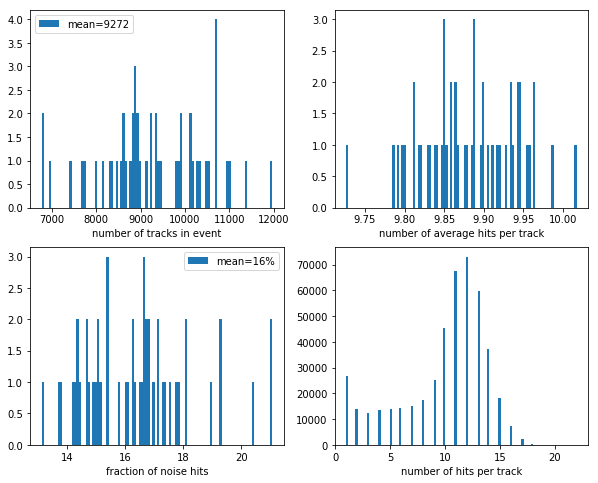

In [8]:
plt.figure(figsize=(10, 8))
plt.subplot(221)
plt.hist(n_trk,100,label=('mean=%d'%int(np.mean(n_trk)))); plt.xlabel('number of tracks in event'); plt.legend()

plt.subplot(222)
plt.hist(average_hits_per_track,100); plt.xlabel('number of average hits per track'); 

plt.subplot(223)
noise_fraction = [ 100*n_noise_hits[k]/(n_truth_hits[k]+n_noise_hits[k]) for k in range(len(n_noise_hits))]
plt.hist(noise_fraction,100, label=('mean=%d%s'%(np.mean(noise_fraction),'%')));
plt.xlabel('fraction of noise hits'); plt.legend()

plt.subplot(224)
plt.hist(n_hits_per_track,100); plt.xlabel('number of hits per track'); 


plt.show()

### Visualizing events:

Let's draw few tracks in event, and fit the curve parameters

The results are give as a set of parameters ${x_i,y_i}$. There is a formal (algebric) approach to calculate the curve paramters on the $X-Y$ plane:


#### Fit of the charged curve ([link](https://dtcenter.org/met/users/docs/write_ups/circle_fit.pdf)):

The solution of the cirve fit is:

$$ u_c\cdot S_{uu} + v_c\cdot S_{uv} = \frac{1}{2}(S_{uuu} + S_{uvv}) $$  
$$ u_c\cdot S_{uv} + v_c\cdot S_{vv} = \frac{1}{2}(S_{vvv} + S_{vuu}) $$  

and 

$$ \rho^2 = u_c^2 + v_c^2 + \frac{1}{N}(S_{uu} + S_{vv}) $$ 

where $(u,v) = (x,y) + (\bar{x},\bar{y})$ coordinates centered around the mean of the set of measured points $\{x_i,y_i\}$


#### track parameters from helix parametrization

Helix parametrization is given by:
\begin{align}
x & =  x_0 + d_0 \cos(\phi_0) + \rho(\cos(\phi_0) - \cos(\phi_0+\phi)) \\
y & = y_0 + d_0 \sin(\phi_0) + \rho(\sin(\phi_0) - \sin(\phi_0+\phi)) \\
z & = z_0 + d_z + (\rho\phi)\tan\lambda
\end{align}

Assume $\vec{X}_0 = 0 $ is the origin, we can fit a curve $(x_c,y_c,\rho)$, and then rest of the track parameters will be given by:
$$(\phi_0, d_0, \phi) = (\arctan(y_c,x_c), \sqrt{x_c^2+y_c^2}-\rho, \arctan(y_c-y,x_c-x) - \phi_0)$$

NOTE: $\phi$ defined to be the angle between track position and pivot point with respect to the helix center. Using this definition $\phi$ increasing for negative charge tracks, and decreasing for possitive charge tracks

The rest two longitudinal parameters are obtained from a streight line fit to: $ z = d_z + (\rho\phi)\tan\lambda $

#### Summary:
from $\{x_i,y_i\}$ by fit to a curve obtain $(x_c,y_c,\rho)$ which translated to $\phi_0,d_0,\rho$ 

from $\{z_i,\phi_i\}$ by fit to a line obtain $(d_z, \tan\lambda)$


## Reconstructing track parameters: ($d_0$,$z_0$,$\rho$,$\phi_0$,$\tan\lambda$)

Using the strategy above, we will expand the `truth` container with track parameters, based on fit to $\{x_i,y_i,z_i\}$.


In [9]:
#from https://scipy-cookbook.readthedocs.io/items/Least_Squares_Circle.html
def fitcircle(x,y):
    x_m = np.mean(x)
    y_m = np.mean(y)
    u = x - x_m
    v = y - y_m
    
    # linear system defining the center (uc, vc) in reduced coordinates:
    #    Suu * uc +  Suv * vc = (Suuu + Suvv)/2
    #    Suv * uc +  Svv * vc = (Suuv + Svvv)/2
    Suv  = np.sum(u*v)
    Suu  = np.sum(u**2)
    Svv  = np.sum(v**2)
    Suuv = np.sum(u**2 * v)
    Suvv = np.sum(u * v**2)
    Suuu = np.sum(u**3)
    Svvv = np.sum(v**3)
    
    # Solving the linear system
    A = np.array([ [ Suu, Suv ], [Suv, Svv]])
    B = np.array([ Suuu + Suvv, Svvv + Suuv ])/2.0
    uc, vc = np.linalg.solve(A, B)

    xc = x_m + uc
    yc = y_m + vc

    # Calcul des distances au centre (xc, yc)
    Ri_1     = np.sqrt((x-xc)**2 + (y-yc)**2)
    R      = np.mean(Ri_1)
    #residu_1 = sum((Ri_1-R_1)**2)
    
    return xc, yc, R, GetSign(x,y,xc,yc)

from scipy import optimize
def calc_R(xc, yc):
    """ calculate the distance of each 2D points from the center (xc, yc) """
    return np.sqrt((x-xc)**2 + (y-yc)**2)

def f_2b(c):
    """ calculate the algebraic distance between the data points and the mean circle centered at c=(xc, yc) """
    Ri = calc_R(*c)
    return Ri - Ri.mean()

def Df_2b(c):
    """ Jacobian of f_2b
    The axis corresponding to derivatives must be coherent with the col_deriv option of leastsq"""
    xc, yc     = c
    df2b_dc    = np.empty((len(c), x.size))

    Ri = calc_R(xc, yc)
    df2b_dc[0] = (xc - x)/Ri                   # dR/dxc
    df2b_dc[1] = (yc - y)/Ri                   # dR/dyc
    df2b_dc    = df2b_dc - df2b_dc.mean(axis=1)[:, np.newaxis]

    return df2b_dc

def fit2circle(x,y):
    center_estimate = np.mean(x), np.mean(y)
    center, ier = optimize.leastsq(f_2b, center_estimate, Dfun=Df_2b, col_deriv=True)
    xc, yc = center
    Ri       = calc_R(*center)
    R        = Ri.mean()
    #residu_2   = sum((Ri - R)**2)
    #check direction of the points:
    q = GetSign(x,y,xc,yc)
    return xc, yc, R, q

def GetIP(xc,yc,R):
    xIP, yIP = xc*(1 - np.abs(R)/np.sqrt(xc**2 + yc**2)), yc*(1 - np.abs(R)/np.sqrt(xc**2 + yc**2))
    phi0 = np.arctan2(yc,xc)
    d0 = np.sqrt(xc**2 + yc**2) - R # d0 has a sign
    return xIP, yIP, d0, phi0

def GetSign(x,y,xc,yc):
    phi = np.unwrap(np.arctan2(y-yc, x-xc))
    q = -(np.sign( np.mean( np.unwrap(phi[1:]-phi[:-1])))) #clockwise - decreasing phi: possitive charge
    return q    

def FitTrackThreePoints(x,y,z):
    #fit {xi,yi} to circle: (x-xc)**2+(y-yc)**2 = rho**2
    dx10 = x[1]-x[0]; dx21=x[2]-x[1]; dy10 = y[1]-y[0]; dy21=y[2]-y[1]
    A = np.array([ [ dx10, dy10 ], [dx21, dy21]]) * 2.0
    B = np.array([ dx10 * (x[1]+x[0]) + dy10*(y[1]+y[0]), dx21 * (x[2]+x[1]) + dy21 * (y[2]+y[1]) ])
    xc, yc = np.linalg.solve(A, B) #solve A*[xc,yc]=B
    rho = np.mean(np.sqrt((x-xc)**2 + (y-yc)**2))
    d0 = np.sqrt(xc**2 + yc**2) - rho
    phi0 = np.arctan2(yc, xc)
    #fit {zi,ri=sqrt(xi**2+yi**2)} to a streight line: z = z0 - r*tanL
    r = np.sqrt(x**2+y**2)
    (tanL,z0) = np.polyfit(-r,z,1)
    return rho,phi0,d0,z0,tanL

def FitTrackTwoPoints(x,y,z):
    '''
    circle that cross the origin, with two points v1=(x1,y1) and v2=(x2,y2) obeys:
    dr = 2*rho*sin(dphi)
    where dr=sqrt(dx**2+dy**2), and dphi is the angle between v1,v2
    '''
    phi = np.arctan2(y,x)
    dphi=acos(cos(phi[1]-phi[0]))      
    dr = np.sqrt((x[1]-x[0])**2+(y[1]-y[0])**2)
    rho =0.5*dr/dphi
    
    '''
    equation of particle propogation in z direction obeys:
    z = z0 - rho*phi*tan(lambda) ~ r*tan(lambda) (from rho*sin(phi/2)~rho*phi/2=r/2)
    where phi is the angle betwen v0 and vi, where v0 pointing to the origin
    then one can write for two points (z1,phi1), (z2,phi2)
    z2 - z1 = -rho(phi2-phi1)tan(lambda) = dr*tan(lambda)
    z0 = zi + ri*tan(lambda)
    '''
    r = np.sqrt(x**2+y**2)
    dz = z[1] - z[0]
    
    tanL = -dz/dr
    z0 = np.mean(z + r*tanL)

    return rho,z0,tanL

def TrackParameters(x,y,z):
    if len(x)<3:
        return 0,0,0,0,0,0
    xc,yc,r,q = fitcircle(x,y)
    phi0 = np.arctan2(yc,xc)
    d0 = np.sqrt(xc**2+yc**2)-r
    phi = np.unwrap(np.arctan2(yc - y, xc - x) - phi0)
    tanL, z0 = np.polyfit(phi*r,z,1)
    return d0,z0,r,phi0,tanL,q

def add_parameters(grp):
    x,y,z = grp['tx'],grp['ty'],grp['tz']
    d0,z0,r,phi0,tanL, q = TrackParameters(x,y,z)
    grp['q'] = q
    grp['z0'] = z0
    grp['d0'] = d0
    grp['rho'] = r
    grp['ntrk'] = len(x)
    return grp

def printStatus(i,n):
    point = n // 100
    increment = n / 75
    if(i % (point) == 0):
        sys.stdout.write("\r[" + "=" * int(i / increment) +  " " * int((n - i)/ increment) + "]" +  str(i / point) + "%")
        sys.stdout.flush()
    if i==(n-1):
        sys.stdount.write('\n')
        

In [10]:
# extend truth info with with additional variables
truth['px'] = truth['tpx']*GeV2MeV
truth['py'] = truth['tpy']*GeV2MeV
truth['pz'] = truth['tpz']*GeV2MeV
truth['pt'] = np.sqrt(truth['tpx']**2 + truth['tpy']**2)*GeV2MeV
truth['p'] = np.sqrt(truth['tpx']**2 + truth['tpy']**2 + truth['tpz']**2)*GeV2MeV
truth['phi'] = np.arctan2(truth['ty'],truth['tx'])
truth['r'] = np.sqrt(truth['ty']**2+truth['tx']**2)
truth['theta'] = np.arctan2(truth['r'],truth['tz'])
truth['eta'] = -np.log(np.tan(0.5*truth['theta']))

# add track parameters using the "TrackParameters" function
group_truth = truth.groupby(by=['particle_id'])
unique_trk = group_truth.size()     #number of hits per track
track_idx = group_truth.indices     #dic of track indeces corresponds to 'particle_id'

#truth = pd.concat([group_truth.apply(add_parameters)]) # this is a short implementation off all lines bellow
truth['d0'],truth['z0'],truth['rho'],truth['phi0'],truth['tanL'],truth['q'] = 0,0,0,0,0,0
i=0; n=len(track_idx)
print('nTracks = ',n)
for pid, idx in track_idx.items():
    if pid==0: continue
    printStatus(i,n); i=i+1
    truth_track = truth.loc[track_idx[pid]]
    x = truth_track['tx'].values
    y = truth_track['ty'].values
    z = truth_track['tz'].values
    d0,z0,rho,phi0,tanL,q = TrackParameters(x,y,z)
    truth.at[idx, 'd0'] = d0
    truth.at[idx, 'z0'] = z0
    truth.at[idx, 'rho'] = rho
    truth.at[idx, 'phi0'] = phi0
    truth.at[idx, 'tanL'] = tanL
    truth.at[idx, 'ntrk'] = len(x)
    truth.at[idx, 'q'] = q

truth['phi'] = (truth['z0'] - truth['tz'])/(truth['rho']*truth['tanL'])

nTracks =  8798
[==========================================================================]101.0%

### Plot of a single track

In [11]:
def PlotMe(idx):   
    xc, yc, R, q = fitcircle(truth['tx'][idx],truth['ty'][idx])
    x0, y0, d0, phi0 = GetIP(xc, yc, R)
    phi = np.unwrap(np.arctan2(yc - truth['ty'][idx], xc - truth['tx'][idx]) - phi0)
    phi_max = np.max(np.abs(phi))*1.1
    phi_fit = np.linspace(0,phi_max,100) if q<0 else np.linspace(-phi_max,0,100)
    
    xlim = (min(-50,1.05*np.min(truth['tx'][idx])),max(50,1.05*np.max(truth['tx'][idx])))
    ylim = (min(-50,1.05*np.min(truth['ty'][idx])),max(50,1.05*np.max(truth['ty'][idx])))

    x_fit = d0*cos(phi0) + R*(cos(phi0) - cos(phi0 + phi_fit))
    y_fit = d0*sin(phi0) + R*(sin(phi0) - sin(phi0 + phi_fit))

    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(2, 2, 1)
    ax.scatter( truth['tx'][idx],truth['ty'][idx],label='measured points'); 
    ax.plot(x_fit,y_fit,'r-',label='Fit')
    ax.scatter(x0,y0,label='IP')
    ax.scatter(0,0,label='origin')
    ax.set_xlim(xlim); ax.set_ylim(ylim)
    ax.set_xlabel('X'); ax.set_ylabel('Y')
    ax.legend()


    ax = fig.add_subplot(2, 2, 2)
    ax.scatter(R*phi,truth['tz'][idx],label='measured points'); 


    (tanL,z0) = np.polyfit(phi*R,truth['tz'][idx],1)
    z_fit = z0 + tanL*phi_fit*R
    ax.plot(phi_fit*R,z_fit,'r-',label='Fit')
    ax.set_xlabel(r'$\rho\phi$ [mm]'); ax.set_ylabel('Z [mm]')
    ax.legend()

    ax = fig.add_subplot(2, 1, 2, projection='3d')
    ax.plot(z_fit,x_fit,y_fit,'r-',label='Fit')
    ax.plot( truth['tz'][idx], truth['tx'][idx], truth['ty'][idx],'ko',label='track hits')
    ax.plot( [0],[0],[0],'go',label='origin')
    ax.legend()
    
    print('parameters from the plotme fit (R,phi0,d0,z0,tanL):',R,phi0,d0,z0,tanL)
    

    plt.show()

data for PID= 828673395271925760
[455.26918769 455.21816611 454.5801878  454.5353651  453.95183563
 453.27800512 450.97520947 450.24347305 449.51283932 448.48063588
 448.38824868 447.53029943 446.62696123]
from circle fit (Xc,Yc)=(664,-235), rho=704.29, pT_0=435
xIP,yIP =  -0.16760910149780725 0.05939007468222036
d0 =  -0.1778201109989368 sqrt(xc**2+yc**2) - rho =  -0.1778201109989368
phi0 = atan(yc,xc) =  -0.3405331 (d0cosphi0,d0sinphi0)=(-0.17,0.06)
pT from circle (0.6R) =  422.576513671875
pT[0] from truth =  435.2480173110962
z0, tanL, q =  -62.16388884602867 0.33001030041126467 1.0
--------------- Perform fit from x,y,px,py ---------------- 
phi0 =  2.7931004528842887
rho+d0 =  -712.01899845725  rho(pt0) =  716.6919646687903 728.2592763461035
ax,ay =  669.2185865634868 -243.14098289271215
tanL = pz/pt =  -0.32494851583349477
TrackParameters: d0=-0.18	z0=-62.16	R=704[mm]	phi0=-0.34	tanL=0.33	q=1
Fit to three points: have total 13 extract  4 fits
999 =(rho,phi0,d0,z0,tanL) (701.5559

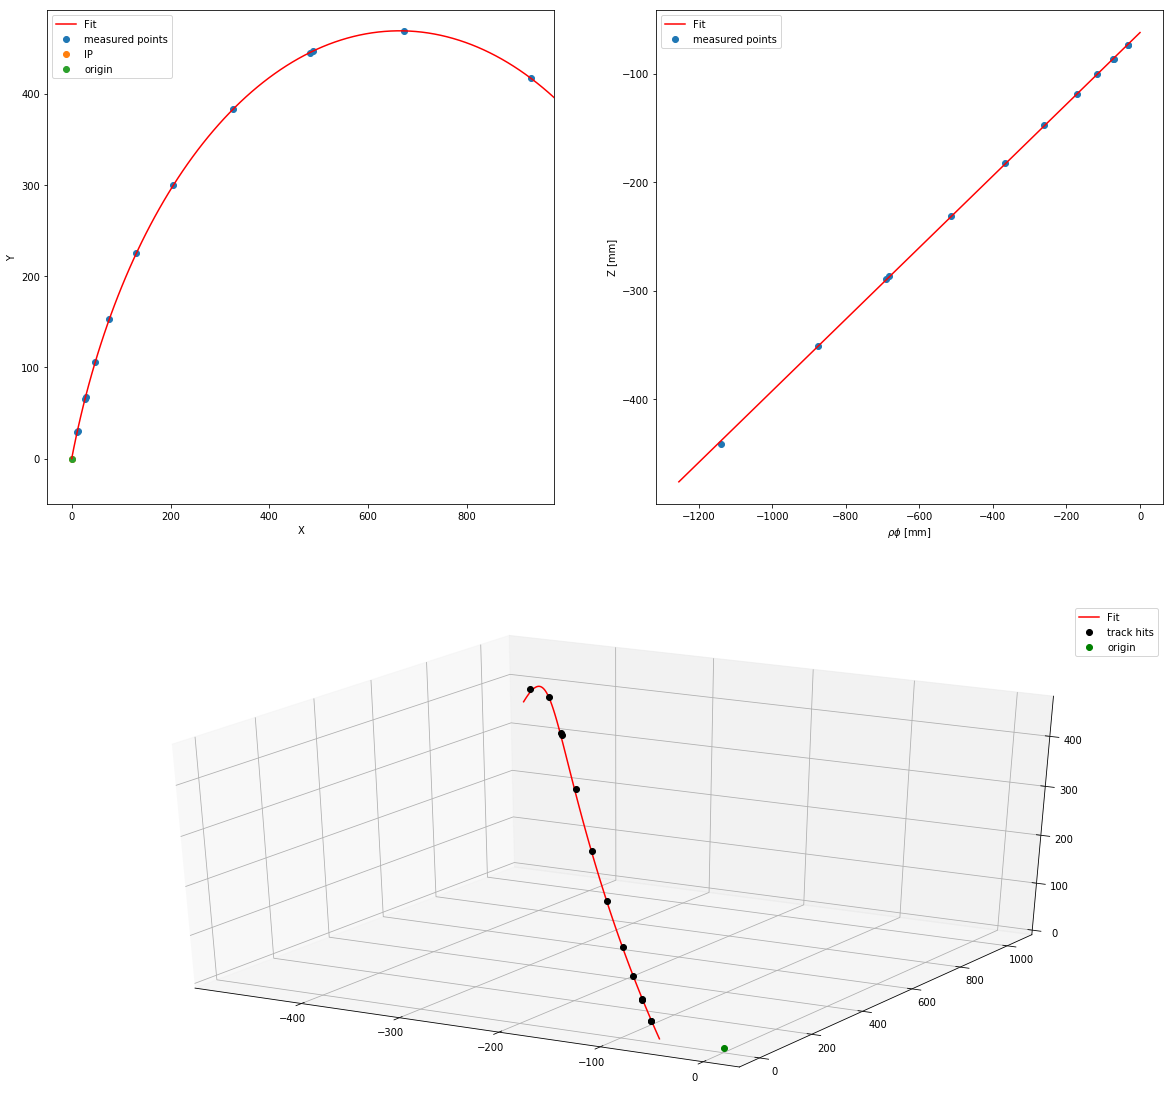

,hit_id,particle_id,tx,ty,tz,tpx,tpy,tpz,weight,px,...,r,theta,eta,d0,z0,rho,phi0,tanL,q,ntrk
16817,16818,828673395271925760,11.242300,29.481800,-73.633003,0.163410,0.403408,-0.133526,0.000015,163.409993,...,31.552588,2.736752,-1.583618,-0.177771,-62.163891,704.294373,-0.340534,0.33001,1.0,13.0
16923,16924,828673395271925760,11.787500,30.824400,-74.077499,0.163916,0.403091,-0.133689,0.000013,163.916007,...,33.001343,2.722489,-1.547996,-0.177771,-62.163891,704.294373,-0.340534,0.33001,1.0,13.0
24639,24640,828673395271925760,27.200001,65.701897,-86.183800,0.184955,0.391752,-0.137714,0.000011,184.955001,...,71.109627,2.451737,-1.023623,-0.177771,-62.163891,704.294373,-0.340534,0.33001,1.0,13.0
24672,24673,828673395271925760,28.067499,67.532799,-86.827797,0.186135,0.391166,-0.137642,0.000009,186.134994,...,73.133186,2.441598,-1.007789,-0.177771,-62.163891,704.294373,-0.340534,0.33001,1.0,13.0
30949,30950,828673395271925760,47.423599,105.575996,-100.407997,0.207449,0.379746,-0.137223,0.000008,207.449004,...,115.738022,2.285389,-0.784548,-0.177771,-62.163891,704.294373,-0.340534,0.33001,1.0,13.0
36572,36573,828673395271925760,75.848503,153.494995,-118.438004,0.234955,0.361502,-0.139905,0.000007,234.954998,...,171.212463,2.175971,-0.645903,-0.177771,-62.163891,704.294373,-0.340534,0.33001,1.0,13.0
63965,63966,828673395271925760,129.572006,225.033005,-147.723999,0.280291,0.324569,-0.139537,0.000005,280.290991,...,259.670471,2.088027,-0.541966,-0.177771,-62.163891,704.294373,-0.340534,0.33001,1.0,13.0
69743,69744,828673395271925760,204.279999,299.558014,-182.123001,0.325337,0.277827,-0.140311,0.000005,325.336993,...,362.581482,2.036278,-0.483264,-0.177771,-62.163891,704.294373,-0.340534,0.33001,1.0,13.0
75600,75601,828673395271925760,325.990997,383.239014,-230.712997,0.375556,0.202593,-0.141335,0.000005,375.555992,...,503.132477,2.000740,-0.443837,-0.177771,-62.163891,704.294373,-0.340534,0.33001,1.0,13.0
80726,80727,828673395271925760,482.394012,444.888000,-286.545013,0.411317,0.109317,-0.141432,0.000005,411.316991,...,656.223511,1.982499,-0.423852,-0.177771,-62.163891,704.294373,-0.340534,0.33001,1.0,13.0


In [13]:
particle_id = list(track_idx.keys())[7979];
#particle_id = 166655657481601024

idx = [track_idx[k] for k in track_idx if k == particle_id][0]
#idx = np.concatenate(idx)
print('data for PID=',particle_id)
truth_track = truth.loc[track_idx[particle_id]]
truth_track = truth_track.sort_values(by = ['p'],ascending=False)

#read variables:
x = truth_track['tx'].values
y = truth_track['ty'].values
z = truth_track['tz'].values
px = truth_track['px'].values
py = truth_track['py'].values
pz = truth_track['pz'].values
pT = truth_track['pt'].values
p = truth_track['p'].values
print(p)
rho_tuple = truth_track['rho'].values

#do the fit
xc, yc, rho, q = fitcircle(x,y) # fit2circle(x,y)
xIP, yIP, d0, phi0 = GetIP(xc, yc, rho)
phi = np.unwrap(phi0 - np.arctan2(yc-y, xc-x))
#charge dependent rho:
#q = -(np.sign( np.mean( np.unwrap(phi[1:]-phi[:-1])))) #clockwise - possitive charge
(bz,az) = np.polyfit(-phi*rho,z,1)


print('from circle fit (Xc,Yc)=(%2.0f,%2.0f), rho=%2.2f, pT_0=%2.0f'%(xc, yc, rho, pT[0]))
print('xIP,yIP = ',xIP,yIP)
print('d0 = ',d0,'sqrt(xc**2+yc**2) - rho = ',np.sqrt(xc**2 + yc**2)-np.abs(rho))
print('phi0 = atan(yc,xc) = ',phi0,'(d0cosphi0,d0sinphi0)=(%2.2f,%2.2f)'%(d0*cos(phi0),d0*sin(phi0)))
print('pT from circle (0.6R) = ',rho*0.6)
print('pT[0] from truth = ',pT[0])
print('z0, tanL, q = ',az, bz, q)
print('--------------- Perform fit from x,y,px,py ---------------- ')
(bx,ax) = np.polyfit(-py,x,1)
(by,ay) = np.polyfit(px,y,1)
phi0_fit = np.arctan2(-ay,-ax)
print('phi0 = ',phi0_fit)
print('rho+d0 = ',ax/cos(phi0_fit),' rho(pt0) = ',pT[0]*bx,pT[0]*by)
print('ax,ay = ',ax,ay)
print('tanL = pz/pt = ',np.mean(pz/pT))
print('TrackParameters: d0=%2.2f\tz0=%2.2f\tR=%2.0f[mm]\tphi0=%2.2f\ttanL=%2.2f\tq=%d'%TrackParameters(x,y,z))
nHits = len(x)
print('Fit to three points: have total',nHits, 'extract ',nHits//3,'fits')
for i in range(len(x)//3):
    x_p = x[i*3:i*3+3]
    y_p = y[i*3:i*3+3]
    z_p = z[i*3:i*3+3]
    #print(i,'=(rho,phi0,d0,z0,tanL)',FitTrackThreePoints(x_p,y_p,z_p))
x_p = np.array([x[0],x[nHits//2],x[-1]])
y_p = np.array([y[0],y[nHits//2],y[-1]])
z_p = np.array([z[0],z[nHits//2],z[-1]])
print(999,'=(rho,phi0,d0,z0,tanL)',FitTrackThreePoints(x_p,y_p,z_p))
print('Fit to two points: have total',nHits, 'extract ',nHits//2,'fits')
for i in range(len(x)//2):
    x_p = x[i*2:i*2+2]
    y_p = y[i*2:i*2+2]
    z_p = z[i*2:i*2+2]
    #print(i,'=(rho,z0,tanL)',FitTrackTwoPoints(x_p,y_p,z_p))
x_p = np.array([x[0],x[-1]])
y_p = np.array([y[0],y[-1]])
z_p = np.array([z[0],z[-1]])
print(999,'=(rho,z0,tanL)',FitTrackTwoPoints(x_p,y_p,z_p))



PlotMe(idx)
truth_track

# Data track parameters

Let's check different distribution of the track parameters:

In [14]:
group_truth = truth.groupby(by=['particle_id'])
unique_trk = group_truth.size()     #number of hits per track
track_idx = group_truth.indices     #dic of track indeces corresponds to 'particle_id'

In [15]:
track_pt = []
track_p = []
track_dpt = []
track_dp = []
track_z0 =[]
track_phi0 =[]
track_tanL =[]
track_d0 =[]
track_rho =[]
pids = []
for pid, idx in track_idx.items():
    if pid==0: continue
    if (len(idx))<3: continue
    pids.append(pid)
    track_pt.append(truth['pt'][idx[0]]*0.001)
    track_p.append(truth['p'][idx[0]]*0.001)
    track_dpt.append( (truth['pt'][idx[0]] - truth['pt'][idx[-1]])/truth['pt'][idx[0]]*0.001 )
    track_dp.append( (truth['p'][idx[0]] - truth['p'][idx[-1]])/truth['p'][idx[0]]*0.001 )
    track_z0.append(truth['z0'][idx[0]])
    track_d0.append(truth['d0'][idx[0]])
    track_phi0.append(truth['phi0'][idx[0]])
    track_rho.append(truth['rho'][idx[0]])
    track_tanL.append(truth['tanL'][idx[0]])

min pT 0.14654967188835144


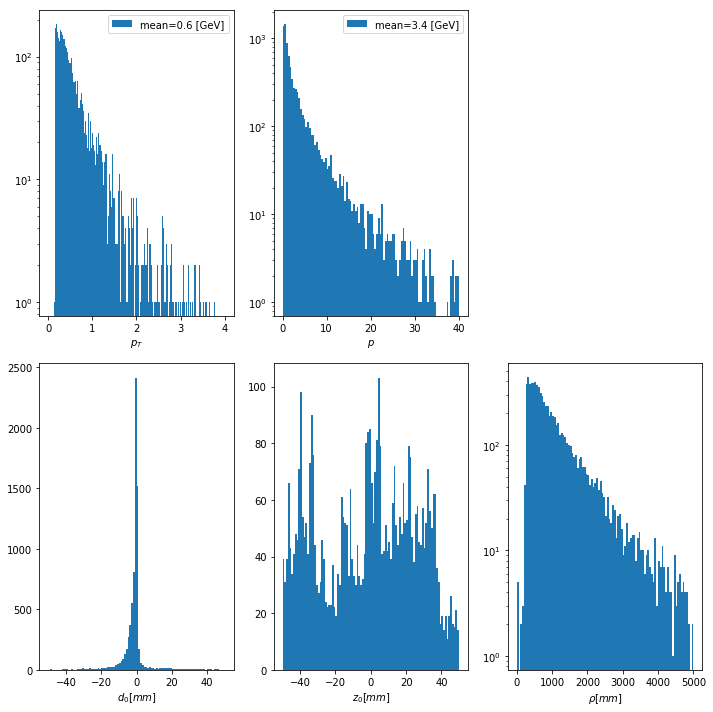

In [16]:
fig = plt.figure(figsize=(10, 10))
plt.subplot(231)
plt.hist(track_pt,400,(0,4),label=('mean=%2.1f [GeV]'%(round(np.mean(track_pt),1))),log=True); plt.xlabel('$p_T$'); plt.legend()
print('min pT',np.min(track_pt))

plt.subplot(232)
plt.hist(track_p,100,(0,40),label=('mean=%2.1f [GeV]'%(round(np.mean(track_p),1))),log=True); plt.xlabel('$p$'); plt.legend()


plt.subplot(234)
plt.hist(track_d0,100,(-50,50)); plt.xlabel('$d_0 [mm]$');

plt.subplot(235)
plt.hist(track_z0,100,(-50,50)); plt.xlabel('$z_0 [mm]$');

plt.subplot(236)
plt.hist(track_rho,100,(1,5000),log=True); plt.xlabel(r'$\rho [mm]$');

plt.tight_layout(); plt.show()

Check anomalies:

## Magnetic field extraction
Extract magnetic field from the data:
$$ B = \frac{p_T}{0.3\cdot \rho} $$
where the $p_T$ is obtained from truth particle info, and $\rho$ from track fit in $X-Y$ plane:

In [17]:
import warnings
warnings.simplefilter('ignore', np.RankWarning)
Npoints = 8
pt_Track = []
B = []
pids = []
Rs = []
etas = []
for pid, idx in track_idx.items():
    if pid==0: continue
    if len(idx) < Npoints: continue
    truth_track = truth.loc[idx]
    truth_track = truth_track.sort_values(by = ['p'],ascending=False)
    if truth_track['pt'].values[0]>1000: continue
    x = truth_track['tx'].values
    y = truth_track['ty'].values
    pT = truth_track['pt'].values[0]
    eta = truth_track['eta'].values[0]
    _, _, R, _ = fitcircle(x,y)  
    B.append(pT/(0.3*R))
    pt_Track.append(pT)
    pids.append(pid)
    Rs.append(R)
    etas.append(eta)
print(' collected ',len(B),'points')

 collected  5782 points


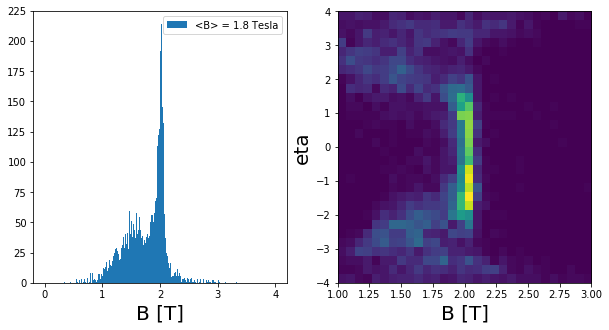

In [18]:
fig = plt.figure(figsize=(10, 5))
(ax1, ax2) = fig.subplots(1,2)
ax1.hist(B,400,(0,4),label='<B> = %2.1f Tesla'%np.mean([b for b in B if b>0 and b<4])); 
ax1.set_xlabel('B [T]',fontsize=20); ax1.legend()
ax2.hist2d(B,etas,bins=30,range=((1,3),(-4,4)))
ax2.set_xlabel('B [T]',fontsize=20); ax2.set_ylabel('eta',fontsize=20)

plt.show()
